# This code will calculate the risk index depending on the weights I will give to each layer.
Number of layers is 6. 
1. Erosion --> if there is erosion, dont build infrastructure. Therefore, risk indev attribute will be 1 (1 means no go zone -- in symbology we will mark is as red)
2. Infrastructure -->if a grid has an infrastructure, we should keep that grid as goos. If a grid is a neighbor to this infrastructure, that nwighboor grid is going to have a good value for risk like it will decrease the value of risk index
3. Contaminated sites --> if a grid has a contaminated sites as Open, then the grid will be directly no-go zone. Similarly if a grid has a neighbour with a contamiinated sites (which is the status is Open) this grid's risk index will increase by 50%. 
4. Ice wedges --> If a grid has an ice wedge, this will increase the risk index value 0.25. 
5. excess Ice --> if the value for a grid is smaller than 0.2, this grid will be good to go. If the value is bigger or equal to 0.2, this grid will increase in risk index as 0.25
6. Drained lakes --> if the drained lake value is 1, then this is a good grid, that can be settled. If the value is in between 0 to 0.5 then this grid will have increase value for risk index for 0.25. 


### But first, we need clean grid_50. Therefore I will delete the grids where they have Null and zero values for excess_ice as this is the values where we dont have excess ice (InSAR) values. I am doing this instead of cutting my grid by raster data - which I couldn do. This is an alternative way. 

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt


/home/emine2/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [3]:
grid_50 = gpd.read_file('/home/emine2/R121/Wainwright/grids/grid50_with_all_data_clipped.shp')
grid_50.head()

,risk_level,suitable_f,drained_la,excess_ice,ice_wedge_,contaminat,building,road,infra_exis,infra_type,erosion_ex,erosion_ye,geometry
0,0.0,True,NaN,0.190489,0,None,0,0,0,None,0,None,"POLYGON ((-230847.77 2301199.894, -230847.77 2..."
1,0.0,True,NaN,0.178978,0,None,0,0,0,None,0,None,"POLYGON ((-230797.77 2301199.894, -230797.77 2..."
2,0.0,True,NaN,0.190013,0,None,0,0,0,None,0,None,"POLYGON ((-230797.77 2301249.894, -230797.77 2..."
3,0.0,True,NaN,0.208342,0,None,0,0,0,None,0,None,"POLYGON ((-230797.77 2301299.894, -230797.77 2..."
4,0.0,True,NaN,0.237193,0,None,0,0,0,None,0,None,"POLYGON ((-230797.77 2301349.894, -230797.77 2..."


In [ ]:
# Filter to keep only rows where 'excess_ice' is not NaN and greater than 0
#grid_50 = grid_50[grid_50['excess_ice'].notna() & (grid_50['excess_ice'] > 0)]
#grid_50.to_file('/home/emine2/R121/Wainwright/grids/grid50_with_all_data_clipped.shp')
#grid_50.head()

,risk_level,suitable_f,drained_la,excess_ice,ice_wedge_,contaminat,building,road,infra_exis,infra_type,erosion_ex,erosion_ye,geometry
24,0.0,True,NaN,0.190489,0,None,0,0,0,None,0,None,"POLYGON ((-230847.77 2301199.894, -230847.77 2..."
53,0.0,True,NaN,0.178978,0,None,0,0,0,None,0,None,"POLYGON ((-230797.77 2301199.894, -230797.77 2..."
54,0.0,True,NaN,0.190013,0,None,0,0,0,None,0,None,"POLYGON ((-230797.77 2301249.894, -230797.77 2..."
55,0.0,True,NaN,0.208342,0,None,0,0,0,None,0,None,"POLYGON ((-230797.77 2301299.894, -230797.77 2..."
56,0.0,True,NaN,0.237193,0,None,0,0,0,None,0,None,"POLYGON ((-230797.77 2301349.894, -230797.77 2..."


In [7]:
# - erosion_ex (0/1)
# - infra_exis (0/1)
# - _contaminat (string like 'Open' or 'Cleanup Complete')
# - ice_wedge (0/1)
# - excess_ice (float)
# - drained_la (float)
# If _contaminat, ice_wedge, or drained_la are missing, add them using similar methods as previous codes (e.g., sjoin for vectors, zonal_stats for rasters)

# Compute neighbor influences

# For infrastructure neighbors
infra_grids = grid_50[grid_50['infra_exis'] == 1]
infra_neighbors = gpd.sjoin(grid_50, infra_grids, predicate='touches', how='left')
infra_neighbor_indices = infra_neighbors.index.unique()  # Unique left indices that touch

# For contaminated neighbors (assuming _contaminat column with 'Open')
contam_grids = grid_50[grid_50['contaminat'] == 'Open']
contam_neighbors = gpd.sjoin(grid_50, contam_grids, predicate='touches', how='left')
contam_neighbor_indices = contam_neighbors.index.unique()

# Initialize risk_index
grid_50['risk_index'] = 0.0

# Add penalties for ice wedges, excess ice, and drained lakes
grid_50['risk_index'] += np.where(grid_50['ice_wedge_'] == 1, 0.25, 0.0)
grid_50['risk_index'] += np.where(grid_50['excess_ice'] >= 0.2, 0.25, 0.0)
grid_50['risk_index'] += np.where((grid_50['drained_la'] >= 0) & (grid_50['drained_la'] <= 0.5), 0.25, 0.0)

# Apply infrastructure influence (decrease risk by 50% if has infra or neighbor)
grid_50['infra_influence'] = 0
grid_50.loc[grid_50['infra_exis'] == 1, 'infra_influence'] = 1
grid_50.loc[infra_neighbor_indices, 'infra_influence'] = 1
grid_50['risk_index'] = np.where(grid_50['infra_influence'] == 1, grid_50['risk_index'] * 0.5, grid_50['risk_index'])

# Apply contaminated neighbor influence (increase risk by 50%)
grid_50['contam_neighbor'] = 0
grid_50.loc[contam_neighbor_indices, 'contam_neighbor'] = 1
grid_50['risk_index'] = np.where(grid_50['contam_neighbor'] == 1, grid_50['risk_index'] * 1.5, grid_50['risk_index'])

# Set no-go zones (risk=1) for erosion or contaminated sites
grid_50['risk_index'] = np.where((grid_50['erosion_ex'] == 1) | (grid_50['contaminat'] == 'Open'), 1.0, grid_50['risk_index'])

# Clip risk_index to [0, 1]
grid_50['risk_index'] = np.clip(grid_50['risk_index'], 0, 1)

# Optionally drop temporary columns
grid_50 = grid_50.drop(columns=['infra_influence', 'contam_neighbor'], errors='ignore')

# Optionally, view the updated head
grid_50.head()

,risk_level,suitable_f,drained_la,excess_ice,ice_wedge_,contaminat,building,road,infra_exis,infra_type,erosion_ex,erosion_ye,geometry,risk_index
0,0.0,True,NaN,0.190489,0,None,0,0,0,None,0,None,"POLYGON ((-230847.77 2301199.894, -230847.77 2...",0.0000
1,0.0,True,NaN,0.178978,0,None,0,0,0,None,0,None,"POLYGON ((-230797.77 2301199.894, -230797.77 2...",0.0000
2,0.0,True,NaN,0.190013,0,None,0,0,0,None,0,None,"POLYGON ((-230797.77 2301249.894, -230797.77 2...",0.0000
3,0.0,True,NaN,0.208342,0,None,0,0,0,None,0,None,"POLYGON ((-230797.77 2301299.894, -230797.77 2...",0.1875
4,0.0,True,NaN,0.237193,0,None,0,0,0,None,0,None,"POLYGON ((-230797.77 2301349.894, -230797.77 2...",0.1875


In [14]:
grid_50.to_file('/home/emine2/R121/Wainwright/grid_50_risk_index.shp')

/tmp/ipykernel_1519560/3202180031.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


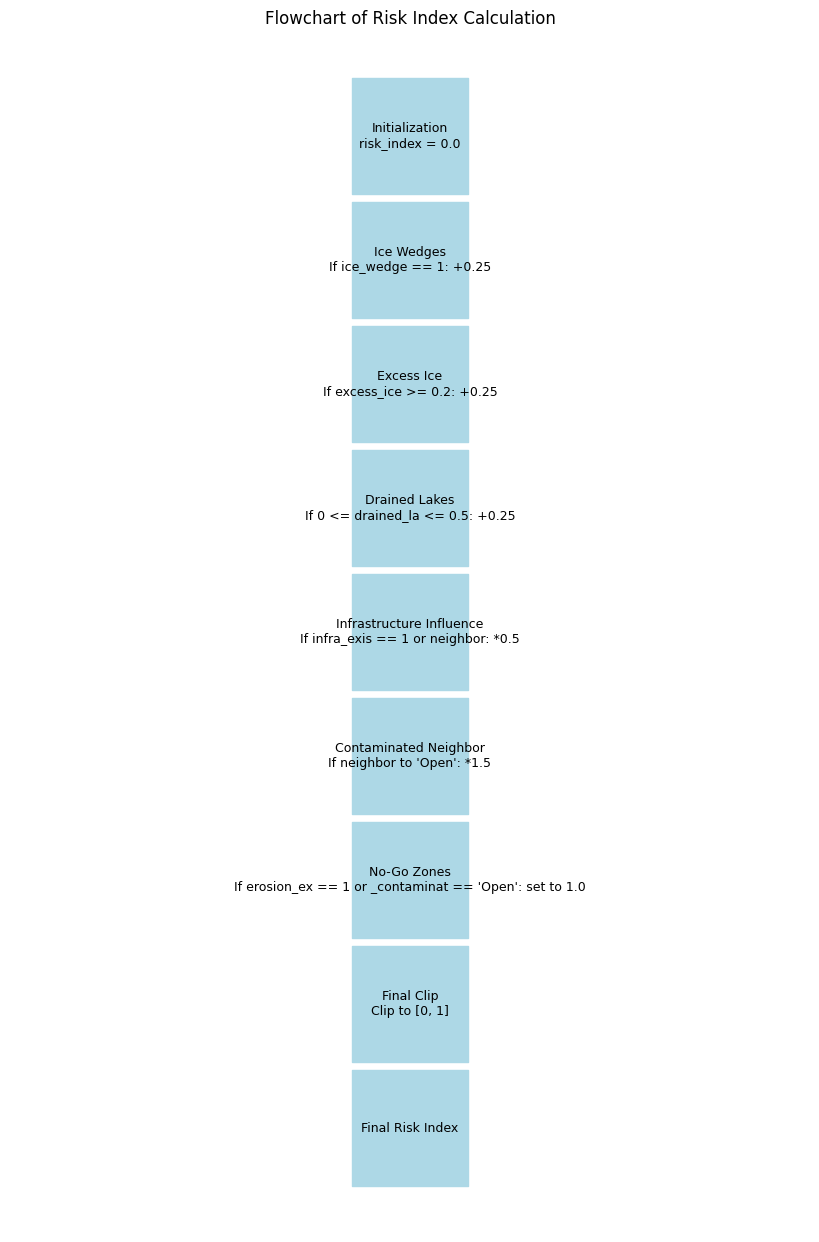

In [15]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
G = nx.DiGraph()

# Add nodes for each step
G.add_node("Start", label="Initialization\nrisk_index = 0.0")
G.add_node("Ice Wedges", label="Ice Wedges\nIf ice_wedge == 1: +0.25")
G.add_node("Excess Ice", label="Excess Ice\nIf excess_ice >= 0.2: +0.25")
G.add_node("Drained Lakes", label="Drained Lakes\nIf 0 <= drained_la <= 0.5: +0.25")
G.add_node("Infra Influence", label="Infrastructure Influence\nIf infra_exis == 1 or neighbor: *0.5")
G.add_node("Contam Neighbor", label="Contaminated Neighbor\nIf neighbor to 'Open': *1.5")
G.add_node("No-Go Zones", label="No-Go Zones\nIf erosion_ex == 1 or _contaminat == 'Open': set to 1.0")
G.add_node("Clip", label="Final Clip\nClip to [0, 1]")
G.add_node("End", label="Final Risk Index")

# Add edges to show the flow
G.add_edge("Start", "Ice Wedges")
G.add_edge("Ice Wedges", "Excess Ice")
G.add_edge("Excess Ice", "Drained Lakes")
G.add_edge("Drained Lakes", "Infra Influence")
G.add_edge("Infra Influence", "Contam Neighbor")
G.add_edge("Contam Neighbor", "No-Go Zones")
G.add_edge("No-Go Zones", "Clip")
G.add_edge("Clip", "End")

# Position the nodes in a vertical layout
pos = {
    "Start": (0, 8),
    "Ice Wedges": (0, 7),
    "Excess Ice": (0, 6),
    "Drained Lakes": (0, 5),
    "Infra Influence": (0, 4),
    "Contam Neighbor": (0, 3),
    "No-Go Zones": (0, 2),
    "Clip": (0, 1),
    "End": (0, 0)
}

# Draw the graph
plt.figure(figsize=(8, 12))
nx.draw(G, pos, with_labels=False, node_size=7000, node_color="lightblue", node_shape="s", font_size=10, font_weight="bold", arrowsize=20)
labels = nx.get_node_attributes(G, 'label')
nx.draw_networkx_labels(G, pos, labels=labels, font_size=9, verticalalignment="center", horizontalalignment="center")

plt.title("Flowchart of Risk Index Calculation")
plt.axis("off")
plt.tight_layout()
plt.show()

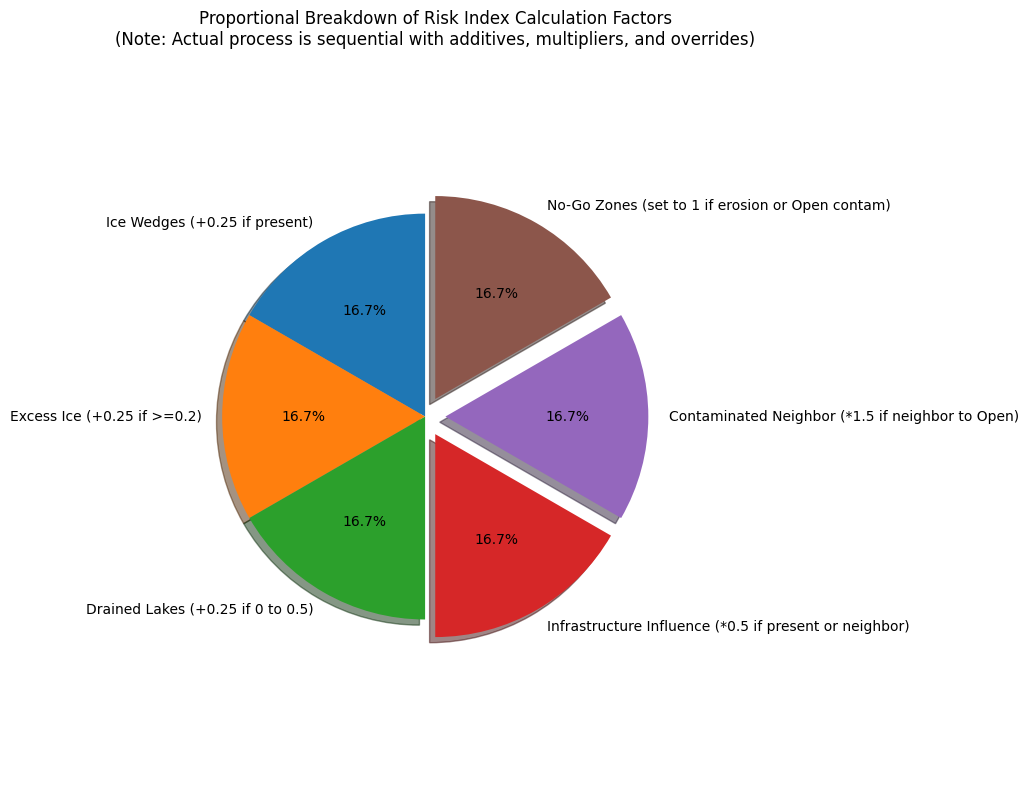

In [9]:
import matplotlib.pyplot as plt

# Define the components and their weights/contributions
labels = [
    'Ice Wedges (+0.25 if present)',
    'Excess Ice (+0.25 if >=0.2)',
    'Drained Lakes (+0.25 if 0 to 0.5)',
    'Infrastructure Influence (*0.5 if present or neighbor)',
    'Contaminated Neighbor (*1.5 if neighbor to Open)',
    'No-Go Zones (set to 1 if erosion or Open contam)'
]
# Since multipliers and set are not additive, we'll assign notional equal shares for visualization
# The clip is final, not a slice
sizes = [16.67] * 6  # Equal parts for illustration, totaling 100%
explode = (0, 0, 0, 0.1, 0.1, 0.1)  # Explode the multiplier and no-go slices for emphasis

# Create the pie chart
fig, ax = plt.subplots(figsize=(10, 8))
ax.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures pie is drawn as a circle

plt.title('Proportional Breakdown of Risk Index Calculation Factors\n(Note: Actual process is sequential with additives, multipliers, and overrides)')
plt.tight_layout()
plt.show()